weight:
[[ 0.00170573]
 [ 0.00074554]
 [-0.00062416]
 [-0.00067746]]
tensor([[ 0.0009],
        [ 0.0004],
        [-0.0003],
        [-0.0003]], dtype=torch.float64)
bias:
[[ 0.00131524  0.0005718  -0.00047327 -0.00051688]]
tensor([[ 0.0013,  0.0006, -0.0005, -0.0005]], dtype=torch.float64)
Epoch: 0/10000		Cost = 8.09e-02		Elapsed time = 0.005261
Epoch: 100/10000		Cost = 6.40e-02		Elapsed time = 0.485855
Epoch: 200/10000		Cost = 6.40e-02		Elapsed time = 0.486266
Epoch: 300/10000		Cost = 6.40e-02		Elapsed time = 0.479000
Epoch: 400/10000		Cost = 6.39e-02		Elapsed time = 0.465267
Epoch: 500/10000		Cost = 6.36e-02		Elapsed time = 0.492873
Epoch: 600/10000		Cost = 6.25e-02		Elapsed time = 0.471101
Epoch: 700/10000		Cost = 5.78e-02		Elapsed time = 0.481286
Epoch: 800/10000		Cost = 5.45e-02		Elapsed time = 0.459063
Epoch: 900/10000		Cost = 4.83e-02		Elapsed time = 0.516022
Epoch: 1000/10000		Cost = 3.79e-02		Elapsed time = 0.484848
Epoch: 1100/10000		Cost = 1.42e-02		Elapsed time = 0.518031

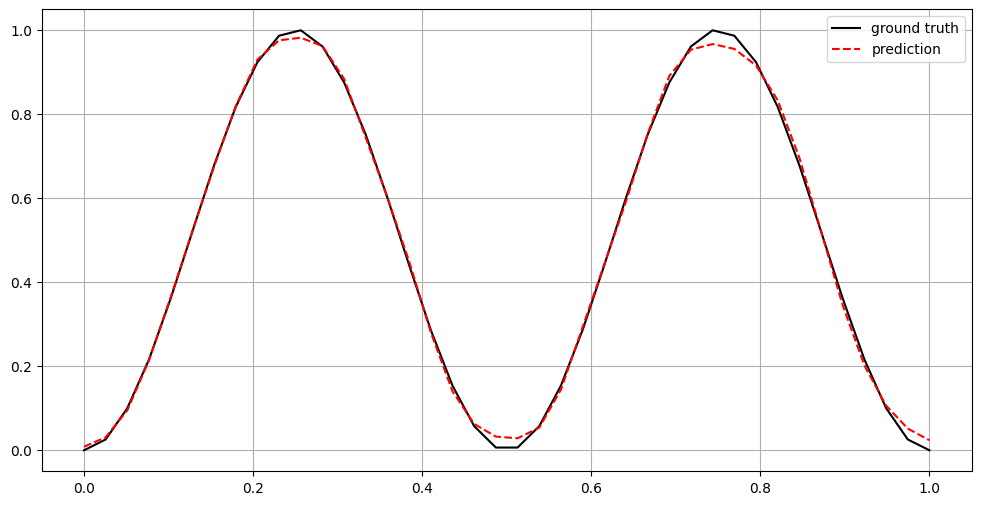

In [13]:
# Exercicio 09

import numpy as np
import torch
import matplotlib.pyplot as plt
import time

class neuralNetwork:
    def __init__(
            self, layers, activation, activationGradient, xavierInitialization=True):
# xavierInitialization=True é uma forma de evitar que o gradiente exploda ou desapareça, através de modelos definidos em pesos de acordo com o número de neurônios de entrada e saida.
        self.L = len(layers)
# len(layers) é o comando para sabermos a quantidade de camadas.
        if xavierInitialization == True:
            self.weights = [
                torch.nn.init.xavier_uniform_(
                    torch.zeros((layers[i], layers[i + 1])),
                    gain=torch.nn.init.calculate_gain("sigmoid"),
                ).numpy()
# torch.nn.init.calculate_gain("sigmoid") é o comando que calcula o fator ideal para inicialização de pesos quando a camada possui função sigmoid (Informação no input)
                for i in range(self.L - 1)
# Inicio do loop
            ]
        else:
            self.weights = [
                np.random.rand(layers[i], layers[i + 1]) for i in range(self.L - 1)
            ]
        self.biases = [np.random.rand(1, layers[i + 1]) for i in range(self.L - 1)]
# np.random.rand gera números aleatórios, cujo valores são de 0 a 1 e terão o tamanho de 1 linha e layers[i+1] colunas
        self.layerActivations = []
# [] criação de uma lista vazia
        self.weightGradients = [
            np.zeros((layers[i], layers[i + 1])) for i in range(self.L - 1)
        ]
        self.biasGradients = [np.zeros((1, layers[i + 1])) for i in range(self.L - 1)]

# helper variables to store gradients per sample

        self.currentWeightGradients = [
            np.zeros((layers[i], layers[i + 1])) for i in range(self.L - 1)
        ]
        self.currentBiasGradients = [
            np.zeros((1, layers[i + 1])) for i in range(self.L - 1)
        ]

        self.activation = activation
        self.activationGradient = activationGradient

    def forward(self, x):
# os valores dentro do () são os inputs.
            self.layerActivations = []  # clear activations
            a = x
            self.layerActivations.append(a)  # activation is not applied to input
            for i in range(self.L - 1):
                z = a @ self.weights[i] + self.biases[i]
# @ é o comando que executa a multiplicação de matrizes.
                self.layerActivations.append(z)  # store activations
                a = self.activation(z)
            return a
    def backward(self, y):
          if len(self.layerActivations) > 0:
              numberOfSamples = len(self.layerActivations[0])

              # for a single sample
              if numberOfSamples == 1:
                  deltaL = -(
                          y - self.activation(self.layerActivations[self.L - 1])
                  ) * self.activationGradient(self.layerActivations[self.L - 1])
                  self.biasGradients[self.L - 2] = deltaL
                  for i in range(
                          self.L - 2
                  ):  # indices of layer activation shifted due to stored input
                      deltal = np.sum(
                          self.weights[self.L - 2 - i]
                          * self.biasGradients[self.L - 2 - i],
                          1,
                      ) * self.activationGradient(self.layerActivations[self.L - 2 - i])
                      self.biasGradients[self.L - 3 - i] = deltal

                  self.weightGradients[0] = (
                          np.transpose(self.layerActivations[0]) @ self.biasGradients[0]
                  )  # without activation for input
                  for i in range(1, self.L - 1):
                      self.weightGradients[i] = (
                              np.transpose(self.activation(self.layerActivations[i]))
                              @ self.biasGradients[i]
                      )

              # for multiple samples using for loop over samples
              elif numberOfSamples > 1:
# elif é uma abreviação de else if
                  for j in range(numberOfSamples):

                      deltaL = -(
                              y[j: j + 1]
                              - self.activation(self.layerActivations[self.L - 1][j: j + 1])
                      ) * self.activationGradient(
                          self.layerActivations[self.L - 1][j: j + 1]
                      )
                      self.currentBiasGradients[self.L - 2] = (
                              deltaL / numberOfSamples
                      )  # division by number of samples, as we are taking the mean
                      self.biasGradients[self.L - 2] += self.currentBiasGradients[
                          self.L - 2
                          ]
                      for i in range(
                              self.L - 2
                      ):  # indices of layer activation shifted due to stored input
                          deltal = np.sum(
                              self.weights[self.L - 2 - i]
                              * self.currentBiasGradients[self.L - 2 - i],
                              1,
                          ) * self.activationGradient(
                              self.layerActivations[self.L - 2 - i][j: j + 1]
                          )
                          self.currentBiasGradients[self.L - 3 - i] = deltal
                          self.biasGradients[self.L - 3 - i] += self.currentBiasGradients[
                              self.L - 3 - i
                              ]
              # without activation for input
                          self.currentWeightGradients[0] = (
                                  np.transpose(self.layerActivations[0][j: j + 1])
                                  @ self.currentBiasGradients[0])
                          self.weightGradients[0] += self.currentWeightGradients[0]
                          for i in range(1, self.L - 1):
                              self.currentWeightGradients[i] = (
                                      np.transpose(
                                          self.activation(self.layerActivations[i][j: j + 1])
                                      )
                                      @ self.currentBiasGradients[i]
                              )
                              self.weightGradients[i] += self.currentWeightGradients[i]

              else:
                  print("backward propagation not possible")

    def zero_grad(self):
        self.weightGradients = [
            np.zeros((layers[i], layers[i + 1])) for i in range(self.L - 1)
        ]
        self.biasGradients = [np.zeros((1, layers[i + 1])) for i in range(self.L - 1)]

    def step(self, lr):
        for i in range(self.L - 1):
            self.weights[i] -= lr * self.weightGradients[i]
            self.biases[i] -= lr * self.biasGradients[i]

# Model Definition

layers = [1, 4, 4, 1]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
# np.exp() é o comando para colocar exponencial.
sigmoidGradient = lambda x: sigmoid(x) * (1 - sigmoid(x))

model = neuralNetwork(layers, sigmoid, sigmoidGradient)

# input data
x = np.expand_dims(np.linspace(0, 1, 2), 1) + 0.2
y = np.sin(4 * np.pi * x) ** 2

# prediction, cost computation & gradient computation

# prediction
yPred = model.forward(x)

# cost
C = 0.5 * np.mean((yPred - y) ** 2)

# gradient
model.backward(y)
# input para calcular os bradientes.

# Verification with PyTorch

# model definition and cloning of model parameters

class neuralNetworkTorch(torch.nn.Module):
# torch.nn.Module é a base para todas as redes neurais
    def __init__(self, layers, activationFunction=torch.nn.Sigmoid()):
        super().__init__()
# o comando super(). chama o __init__ de outra rede neural.
        modules = []
        for i in range(len(layers) - 1):
            modules.append(torch.nn.Linear(layers[i], layers[i + 1]))
            modules.append(activationFunction)

        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)


modelTorch = neuralNetworkTorch(layers)

# copy parameters
with torch.no_grad():
# torch.no_grad() é o comando para executar sem calcular os gradientes.
    for i, param in enumerate(modelTorch.parameters()):
        if i % 2 == 0:
            param.data = torch.from_numpy(model.weights[i // 2]).to(torch.float64).t()
        else:
            param.data = torch.from_numpy(model.biases[i // 2]).to(torch.float64)

# prediction, cost computation & gradient computation

xTorch = torch.from_numpy(x).to(torch.float64)
yPredTorch = modelTorch.forward(xTorch)

CTorch = 0.5 * torch.mean((yPredTorch - torch.from_numpy(y).to(torch.float64)) ** 2)
CTorch.backward()

# gradient comparison

layer = 0
# weight gradients
print("weight:")
print(np.transpose(model.weightGradients[layer]))
print(list(modelTorch.parameters())[2 * layer].grad)

# bias gradients
print("bias:")
print(model.biasGradients[layer])
print(list(modelTorch.parameters())[2 * layer + 1].grad)

# Capítulo 2, exercício 6:

class AdamOptimizer:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.n = None
        self.t = 0

    def updateParams(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(param) for param in params]
        if self.n is None:
            self.n = [np.zeros_like(param) for param in params]

        self.t += 1  # exponent increases with epochs
        updatedParams = []

        for p, g, m, n in zip(params, grads, self.m, self.n):
            m[:] = self.beta1 * m + (1 - self.beta1) * g
            n[:] = self.beta2 * n + (1 - self.beta2) * (g ** 2)

            mhat = m / (1 - self.beta1 ** self.t)
            nhat = n / (1 - self.beta2 ** self.t)

            updatedParams.append(p - self.lr * mhat / (np.sqrt(nhat) + self.epsilon))

        return updatedParams

# Learning with the custom neural network

# Escolha do otimizador
# selectOptimizer = "gradientDescent"
selectOptimizer = 'Adam'

# model definition

layers = [1, 20, 20, 1]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoidGradient = lambda x: sigmoid(x) * (1 - sigmoid(x))

model = neuralNetwork(layers, sigmoid, sigmoidGradient)

x = np.expand_dims(np.linspace(0, 1, 40), 1)  # training grid

if selectOptimizer == "gradientDescent":
    y = x ** 2
    epochs = 10000
    lr = 1e-1
elif selectOptimizer == "Adam":
    y = np.sin(2 * np.pi * x) ** 2  # a more difficult function
    lr = 1e-2
    optimizer = AdamOptimizer(lr=lr)

# training loop

start = time.perf_counter()
for epoch in range(epochs):

    model.zero_grad()
    yPred = model.forward(x)
    C = 0.5 * np.mean((yPred - y) ** 2)
    model.backward(y)

    if selectOptimizer == "gradientDescent":
        model.step(lr)
    elif selectOptimizer == "Adam":
        updatedParameters = optimizer.updateParams(
            model.weights + model.biases, model.weightGradients + model.biasGradients
        )
        model.weights = updatedParameters[: model.L - 1]
        model.biases = updatedParameters[model.L - 1:]

    if epoch % 100 == 0:
        elapsedTime = time.perf_counter() - start
        string = "Epoch: {}/{}\t\tCost = {:.2e}\t\tElapsed time = {:2f}"
        print(string.format(epoch, epochs, C, elapsedTime))
        start = time.perf_counter()

# visualize the prediction

yPred = model.forward(x)

fig, ax = plt.subplots(figsize=(12, 6))
ax.grid()
ax.plot(x, y, "k", label="ground truth")
ax.plot(x, yPred, "r--", label="prediction")
ax.legend()
plt.show()

Epoch: 0/10000		Cost = 7.53e-02		Elapsed time = 0.020503
Epoch: 100/10000		Cost = 6.40e-02		Elapsed time = 0.103161
Epoch: 200/10000		Cost = 6.40e-02		Elapsed time = 0.125770
Epoch: 300/10000		Cost = 6.38e-02		Elapsed time = 0.112819
Epoch: 400/10000		Cost = 6.04e-02		Elapsed time = 0.105920
Epoch: 500/10000		Cost = 5.28e-02		Elapsed time = 0.128585
Epoch: 600/10000		Cost = 3.32e-02		Elapsed time = 0.107239
Epoch: 700/10000		Cost = 8.94e-03		Elapsed time = 0.109386
Epoch: 800/10000		Cost = 1.17e-03		Elapsed time = 0.110332
Epoch: 900/10000		Cost = 7.11e-04		Elapsed time = 0.108672
Epoch: 1000/10000		Cost = 5.06e-04		Elapsed time = 0.105926
Epoch: 1100/10000		Cost = 3.88e-04		Elapsed time = 0.101595
Epoch: 1200/10000		Cost = 3.12e-04		Elapsed time = 0.126626
Epoch: 1300/10000		Cost = 2.60e-04		Elapsed time = 0.105160
Epoch: 1400/10000		Cost = 2.23e-04		Elapsed time = 0.111076
Epoch: 1500/10000		Cost = 1.97e-04		Elapsed time = 0.107233
Epoch: 1600/10000		Cost = 1.77e-04		Elapsed time = 0

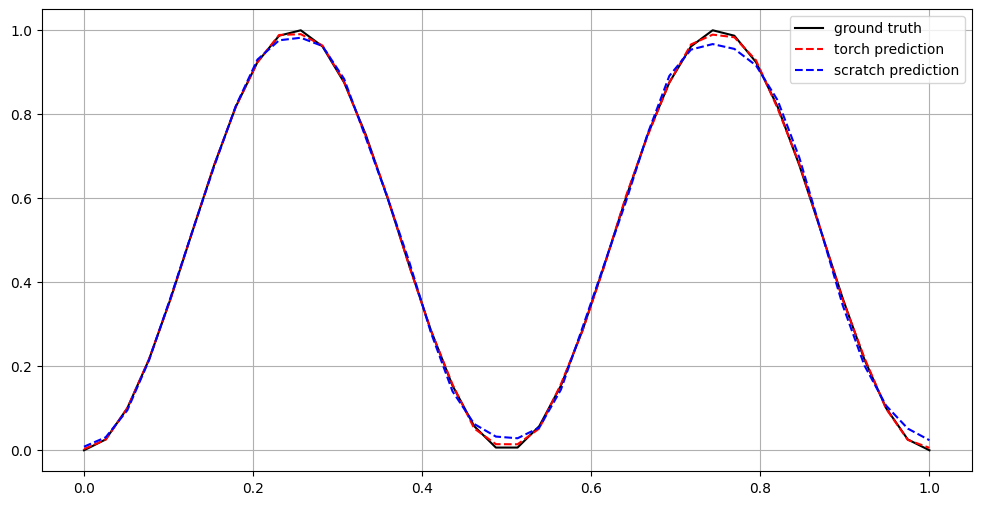

In [14]:
# Utilização para ver o resultado utilizando PyTorch

# Model defitinion
modelTorch = neuralNetworkTorch(layers)
xTorch = torch.from_numpy(x).to(torch.float32)
yTorch = torch.from_numpy(y).to(torch.float32)
if selectOptimizer == "gradientDescent":
    optimizer = torch.optim.SGD(modelTorch.parameters(), lr)
elif selectOptimizer == "Adam":
    optimizer = torch.optim.Adam(modelTorch.parameters(), lr)

# Training loop
start = time.perf_counter()
for epoch in range(epochs):
    optimizer.zero_grad()
    yPredTorch = modelTorch.forward(xTorch)
    CTorch = 0.5 * torch.mean((yPredTorch - yTorch) ** 2)
    CTorch.backward()

    optimizer.step()

    if epoch % 100 == 0:
        elapsedTime = time.perf_counter() - start
        string = "Epoch: {}/{}\t\tCost = {:.2e}\t\tElapsed time = {:2f}"
        print(string.format(epoch, epochs, CTorch.detach(), elapsedTime))
        start = time.perf_counter()

# Visualize the predictions

fig, ax = plt.subplots(figsize=(12, 6))
ax.grid()
ax.plot(x, y, "k", label="ground truth")
ax.plot(xTorch, yPredTorch.detach(), "r--", label="torch prediction")
ax.plot(xTorch, yPred, "b--", label="scratch prediction")
ax.legend()
plt.show()